In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import seaborn as sns
from numpy import mean as npMean
import re
from Module.MetricsGroup import DoAggMetric, DoSimEval


### Metric table load

In [2]:
NumGene_CL = 100


ModelList = ['CFR', 'RCFR', 'RCFR_AC_W:1', 'RCFR_AC_W:2', 'RCFR_AC_W:3' ]

DIR = './MetricTables/'
MetricTableList = os.listdir(DIR)
MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and str(NumGene_CL) in i and 'ACNOCOMX' not in i ]

PosMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Pos' in i} 
NegMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Neg' in i} 

for i in PosMetTabDic:
    PosMetTabDic[i]['Model'] = i.replace('_Pos', '')
    
for i in NegMetTabDic:
    NegMetTabDic[i]['Model'] = i.replace('_Neg', '')

## Metric table merge

In [3]:
PosMetricTotal = pd.concat(PosMetTabDic).reset_index(drop=True)
NegMetricTotal = pd.concat(NegMetTabDic).reset_index(drop=True)

PosMetricTotal['Model'] = PosMetricTotal['Model'].replace({'NOCL_W0':'$_{NoCL}$', 'NOSim_W0':'$_{NoSim}$', '_NoRisk':'$_{NoGROM}$' ,'_W0':'$_{W:1}$', '_W10':'$_{W:2}$', '_W20':'$_{W:3}$', }, regex=True)
NegMetricTotal['Model'] = NegMetricTotal['Model'].replace({'NOCL_W0':'$_{NoCL}$', 'NOSim_W0':'$_{NoSim}$', '_NoRisk':'$_{NoGROM}$' ,'_W0':'$_{W:1}$', '_W10':'$_{W:2}$', '_W20':'$_{W:3}$', }, regex=True)


NegMetricTotal.columns = [i.replace('Neg','') for i in NegMetricTotal.columns.tolist()]
PosMetricTotal.columns = [i.replace('Pos','') for i in PosMetricTotal.columns.tolist()]

NegMetricTotal['Sign'] = 'Negative'
PosMetricTotal['Sign'] = 'Positive'
Agg_MetricTotal = pd.concat([PosMetricTotal, NegMetricTotal], axis=0)

## Performance plot for both Patient and Gene-side  

In [4]:
def PerformancebyModel (TestColName, TestLabelName, MetricTotal, ModelList, TitleList, Leg=True):
    plt.figure(figsize=(20,10))

    
    #sns.set_theme(style="darkgrid")
    
    for numi, i in enumerate(TestColName):
        plt.subplot(2,2,numi+1)
        #sns.violinplot(x='Model' ,y=i, scale="width", data=MetricTotal, cut=0,  order=ModelList)
        #sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, color='lightseagreen', order=ModelList,linestyles='-', capsize=0.1, err_style='bars',errwidth=1.5)

        if numi != 0:
            ax = sns.swarmplot(x="Model", y=i, data=MetricTotal, order=ModelList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
            sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, order=ModelList,
                          capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "--"], scale=1.)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend_.remove()
        else:
            ax = sns.swarmplot(x="Model", y=i, data=MetricTotal, order=ModelList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
            sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, order=ModelList,
                          capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "--"], scale=1.)
            handles, labels = ax.get_legend_handles_labels()
            #ax.legend(handles[:2], labels[:2],bbox_to_anchor=(1.25, 0.65), loc=0, ncol=1,  prop={'size': 14})
            
            if Leg:
                ax.legend(handles[:2], labels[:2], prop={'size': 14})
            else:
                ax.legend_.remove()
 

        plt.xticks(fontsize=15, rotation=20)
        plt.xlabel('', size=16, labelpad=10)
        plt.title(TitleList[numi], size=20, pad=13)
        plt.ylabel(TestLabelName[numi], size=16 )
        #plt.ylim(bottom=-0.05)
        plt.subplots_adjust(hspace=0.4,wspace=0.15)

c:\users\user\anaconda3\envs\ai\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\user\anaconda3\envs\ai\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\user\anaconda3\envs\ai\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


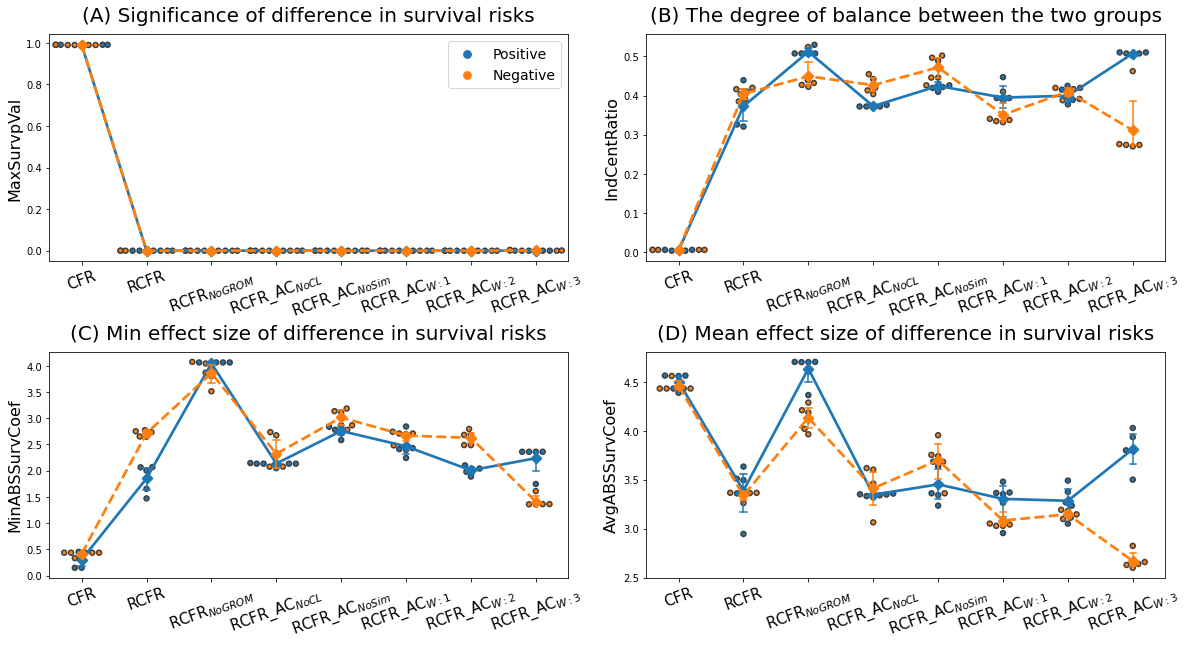

In [5]:
TestColName = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef']
TestLabelName = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef']
TitleList = ['(A) Significance of difference in survival risks',
          '(B) The degree of balance between the two groups',
          '(C) Min effect size of difference in survival risks',
          '(D) Mean effect size of difference in survival risks']

PerformancebyModel(TestColName, TestLabelName, Agg_MetricTotal, np.unique(PosMetricTotal['Model']).tolist(), TitleList, True)
plt.savefig('./Figures/PatientSide_Performance.png')


c:\users\user\anaconda3\envs\ai\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


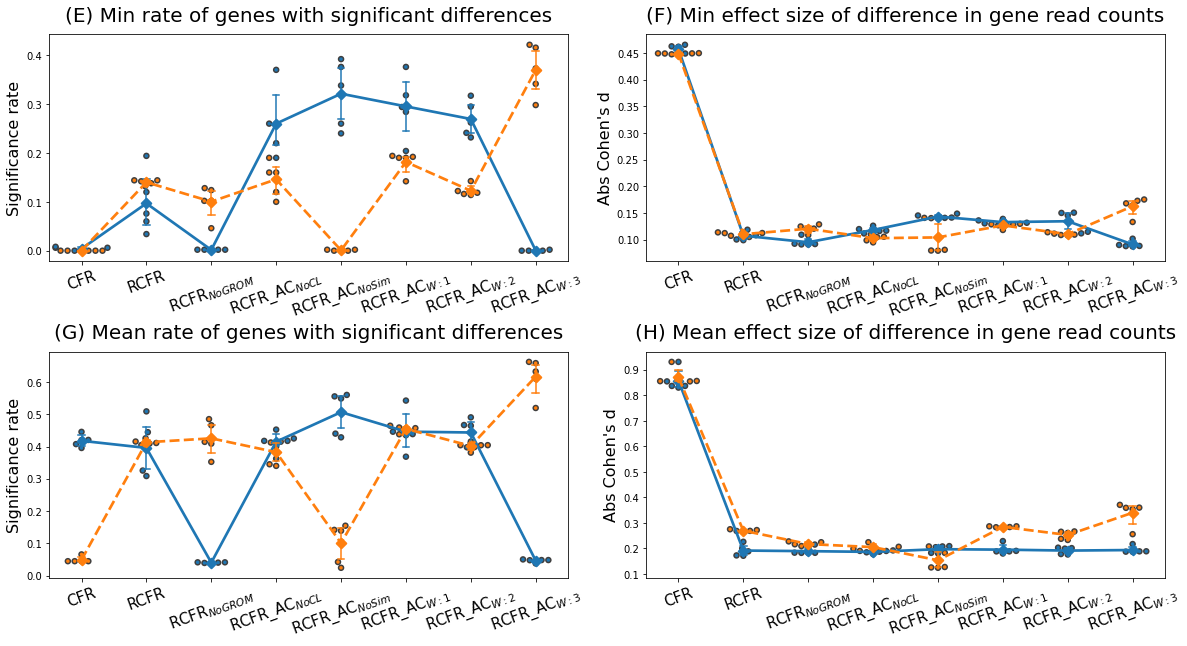

In [6]:
TestColName = ['MinSigRate', 'MinABSGeCohD','AvgSigRate', 'AvgABSGeCohD' ]
TestLabelName = ["Significance rate", "Abs Cohen's d", "Significance rate", "Abs Cohen's d"]
TitleList = ['(E) Min rate of genes with significant differences',
      '(F) Min effect size of difference in gene read counts',
      '(G) Mean rate of genes with significant differences',
      '(H) Mean effect size of difference in gene read counts']

PerformancebyModel(TestColName, TestLabelName, Agg_MetricTotal, np.unique(PosMetricTotal['Model']).tolist(), TitleList, False)
plt.savefig('./Figures/GeneSide_Performance.png')


## Performance table

In [7]:
Cols = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef' , 'MinSigRate', 'AvgSigRate','MinABSGeCohD', 'AvgABSGeCohD']
RateCols = ['IndCentRatio','MinSigRate', 'AvgSigRate']
PerformanceTable = Agg_MetricTotal.groupby(['Sign','Model']).mean()[Cols]
PerformanceTable[RateCols] = PerformanceTable[RateCols]*100
PerformanceTable = np.round(PerformanceTable, 3)
PerformanceTable[RateCols] = PerformanceTable[RateCols].astype('str')+ '%'

PerformanceTable['MaxSurvpVal'] = PerformanceTable['MaxSurvpVal'].astype('str')
PerformanceTable['MaxSurvpVal'] = PerformanceTable['MaxSurvpVal'].replace({'0.0':'p<0.001'})
PerformanceTable.to_csv('./MetricTables/PerformanceTable.csv')

### Data load for best model selection 

In [8]:
DIR = './MetricTables/'
MetricTableList = os.listdir(DIR)
#MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and str(NumGene_CL) in i ]
MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and str(NumGene_CL) in i and 'ACNOCOMX' not in i ]


PosMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Pos' in i} 
NegMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Neg' in i} 

PosMetricTotal = pd.concat(PosMetTabDic).reset_index(drop=True)
PosMetricTotal['GroupM'] = np.array([re.findall('.\d+', i)[2][1:] for i in  PosMetricTotal['Model']])
PosMetricTotal['EpNum'] = np.array([ re.findall('.\d+\.', i)[0][1:-1] for i in  PosMetricTotal['Model']]).astype('int')

NegMetricTotal = pd.concat(NegMetTabDic).reset_index(drop=True)
NegMetricTotal['GroupM'] = np.array([re.findall('.\d+', i)[2][1:] for i in  NegMetricTotal['Model']])
NegMetricTotal['EpNum'] = np.array([ re.findall('.\d+\.', i)[0][1:-1] for i in  NegMetricTotal['Model']]).astype('int')


### Model level filtering

In [9]:
SelectiveKeyword = 'M04_RCFR_AC_W0'
ModelFilter = [SelectiveKeyword in i.Model for i in NegMetricTotal.iloc]
NegMetricTotal = NegMetricTotal[ModelFilter]

ModelFilter = [SelectiveKeyword in i.Model for i in PosMetricTotal.iloc]
PosMetricTotal = PosMetricTotal[ModelFilter]


### Best model selection

In [10]:
def Aggregation(MetricTable,AggMetricList):
    
    AggMetricRank = DoAggMetric(AggMetricList, MetricTable[['Model']+AggMetricList]).sort_values('Metrics')
    AggMetricRank = pd.merge(AggMetricRank, MetricTable[['Model','MaxSurvpVal']], on='Model', how='left')
    BestModel = AggMetricRank.sort_values('Metrics').iloc[-1]

    return AggMetricRank, BestModel

In [11]:
pCutoff = 0.005
ExcRate = 0.2
NmodEahG = 1

NegMetricList = ['IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef',  'MinNegSigRate', 'AvgNegSigRate', 'MinABSGeCohD', 'AvgABSGeCohD']
PosMetricList = ['IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef', 'MinPosSigRate', 'AvgPosSigRate', 'MinABSGeCohD', 'AvgABSGeCohD']


NegAggMetricRank, NegBestModel =  Aggregation(NegMetricTotal, NegMetricList)
PosAggMetricRank, PosBestModel =  Aggregation(PosMetricTotal, PosMetricList)

NegBestModel, PosBestModel

(Model                 M04_RCFR_AC_W0_S4_Epo27.hdf5
 IndCentRatio                              0.340471
 MinABSSurvCoef                             2.74294
 AvgABSSurvCoef                             3.05212
 MinNegSigRate                                0.194
 AvgNegSigRate                               0.4645
 MinABSGeCohD                              0.129616
 AvgABSGeCohD                              0.286712
 NormIndCentRatio                          0.109338
 NormMinABSSurvCoef                               1
 NormAvgABSSurvCoef                       0.0987801
 NormMinNegSigRate                                1
 NormAvgNegSigRate                                1
 NormMinABSGeCohD                                 1
 NormAvgABSGeCohD                                 1
 Metrics                                    5.20812
 MaxSurvpVal                                      0
 Name: 4, dtype: object,
 Model                 M04_RCFR_AC_W0_S3_Epo55.hdf5
 IndCentRatio                          

### Performance difference by sign according to epoch 

In [12]:
DIR = './MetricTables/'
MetricTableList = os.listdir(DIR)
MetricTableList = [i for i in MetricTableList if 'MetricTable' in i and str(NumGene_CL) in i and 'ACNOCOMX' not in i and 'ACNOCLMetricTable_W10' not in i ]
MetricTableList += ['RCFR_NoRiskRank_MetricTable.csv']
MetTabDic = {i.replace('MetricTable_', '').replace('Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList} 


for i in MetTabDic:
    MetTabDic[i]['Model'] = i
    
MetTabDic = pd.concat(MetTabDic).reset_index(drop=True)
MetTabDic['Model'] = MetTabDic['Model'].replace({'_NoRiskRank_MetricTable.csv':'$_{NoGROM}$', 'NOCLW0_':'$_{NoCL}$', 'NOSimW0_':'$_{NoSim}$', 
                                                 'W0_':'$^{†1}$', 'W10_':'$^{†2}$', 'W20_':'$^{†3}$', }, regex=True)


In [13]:
def ToLong (Data):
    
    LongMetTabDic =  pd.melt(Data, id_vars=['Model','EpNum'], value_vars=['AvgNegSigRate','AvgPosSigRate','MinNegSigRate','MinPosSigRate']).copy()
    LongMetTabDic = LongMetTabDic.rename(columns={'value':'Rate'})

    LongMetTabDic['Metric'] = 'Min'
    LongMetTabDic['Sign'] = 'Neg.'

    LongMetTabDic.loc[LongMetTabDic['variable'].str.contains('Avg'), 'Metric'] = 'Mean'
    LongMetTabDic.loc[LongMetTabDic['variable'].str.contains('Pos'), 'Sign'] = 'Pos.'
    
    return LongMetTabDic


ModelList = np.unique(MetTabDic['Model'])
MetTabDic = {i:ToLong(MetTabDic[MetTabDic['Model']==i]) for i in ModelList}


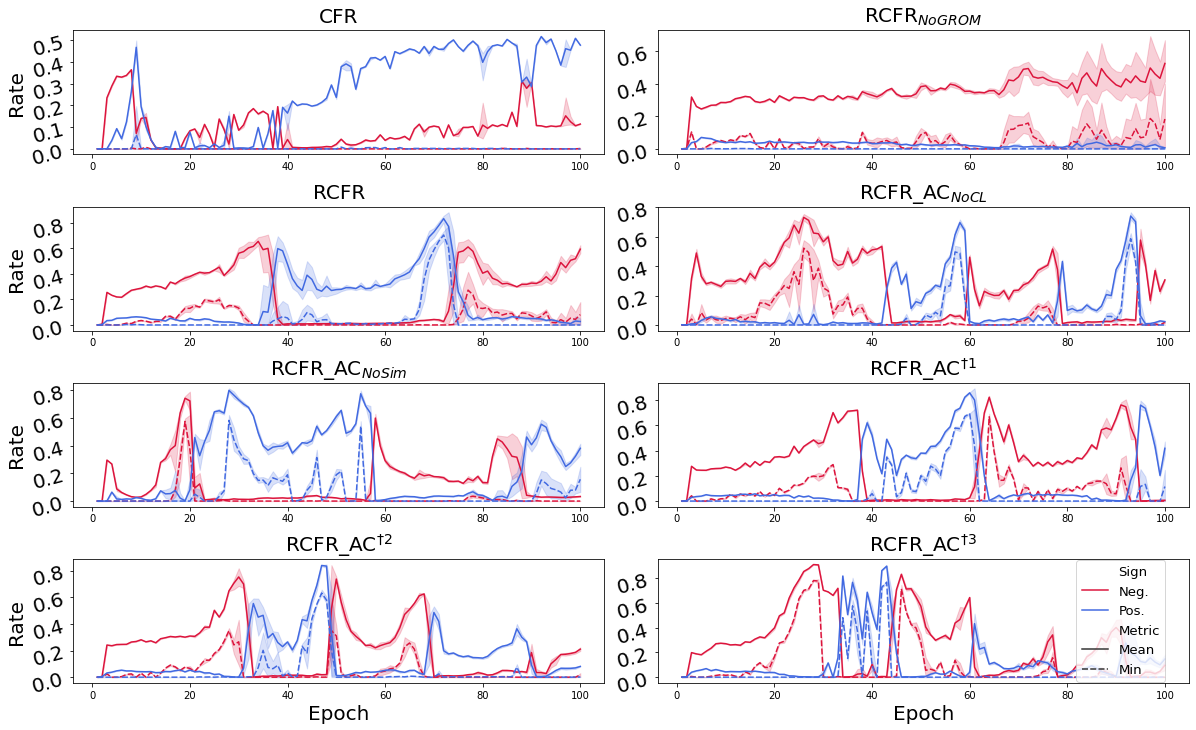

In [14]:
ModelListOrder = ['CFR', 'RCFR$_{NoGROM}$', 'RCFR', 'RCFR_AC$_{NoCL}$', 'RCFR_AC$_{NoSim}$', 'RCFR_AC$^{†1}$', 'RCFR_AC$^{†2}$', 'RCFR_AC$^{†3}$']

plt.figure(figsize=(20, 12))

for numi, i in enumerate(ModelListOrder):
    plt.subplot(4,2,numi+1)
    
    if numi != len(ModelListOrder)-1:
        sns.lineplot(x="EpNum", y="Rate", data=MetTabDic[i], hue='Sign', palette=['crimson','royalblue'], style='Metric', legend=False)
        
    else:
        sns.lineplot(x="EpNum", y="Rate", data=MetTabDic[i], hue='Sign', palette=['crimson','royalblue'], style='Metric', legend=True)
        plt.legend(bbox_to_anchor=(0.788, 0.99), loc=2, borderaxespad=0., prop={'size': 13.2}, ncol=1)    
        #plt.legend(bbox_to_anchor=(0.00, -0.3), loc=2, borderaxespad=0., prop={'size': 13}, ncol=2, title='')    
        #plt.legend(prop={'size': 13}, ncol=1)    
        
        
    if numi >= len(ModelListOrder)-2:
        plt.xlabel('Epoch', size=20)
    else:
        plt.xlabel('')
            
    if numi % 2 ==0:
        plt.ylabel('Rate', size=20 )
    else:
        plt.ylabel('')
    
    plt.title(i, size=20, pad=8)
    plt.yticks(fontsize=20, rotation=15)
    
    plt.subplots_adjust(hspace=0.42,wspace=0.1)

    
plt.savefig('./Figures/SigPerformance_epoch.png')

### Performance difference over epoch

In [15]:
def PerformancebyNumGene_CL (TestColName, TestLabelName, MetricTotal, ModelList, AxisList, TitleList):
    plt.figure(figsize=(20,11))

    IMNum = 0
    for numi, i in enumerate(ModelList):
        for numj, j in enumerate(TestColName):
            plt.subplot(len(ModelList),len(TestColName),IMNum+1)

            if IMNum != 5:
                ax = sns.swarmplot(x='NumGene_CL', y=j, data=MetricTotal[MetricTotal['GroupM']==i], palette=['crimson','royalblue'], order=AxisList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
                sns.pointplot(x ='NumGene_CL', y=j, data=MetricTotal[MetricTotal['GroupM']==i], estimator=npMean, order=AxisList, palette=['crimson','royalblue'],
                              capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "-"], scale=0.8)
                handles, labels = ax.get_legend_handles_labels()
                ax.legend_.remove()
            else:
                ax = sns.swarmplot(x='NumGene_CL', y=j, data=MetricTotal[MetricTotal['GroupM']==i], palette=['crimson','royalblue'], order=AxisList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
                sns.pointplot(x ='NumGene_CL', y=j, data=MetricTotal[MetricTotal['GroupM']==i], estimator=npMean, order=AxisList, palette=['crimson','royalblue'],
                              capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "-"], scale=0.8)
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[:2], labels[:2],bbox_to_anchor=(1., 0.65), loc=0, ncol=1,  prop={'size': 14})

            if IMNum >= 4:
                ax.set_xlabel('The max number of genes in a cluster (Kn)', size=20, labelpad=5)
            else:
                ax.set_xlabel('', size=1, labelpad=5)

            plt.xticks(fontsize=20, rotation=15)
            plt.yticks(np.arange(0, 0.8, step=0.1), fontsize=20, rotation=15)
            ax.set_ylabel(TitleList[numj], size=20 )
            
            plt.subplots_adjust(hspace=0.45,wspace=0.14)
            plt.title(ModelList[numi],fontsize=20, pad=10)
            IMNum += 1
            

In [16]:
DIR = './MetricTables/'
MetricTableList = os.listdir(DIR)
#MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and SelectiveKeyword in i and 'ACNOCOMX' not in i and 'ACNO' not in i]
MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and 'RCFR_AC' in i and 'ACNO' not in i]


PosMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+re.findall('.\d+', i)[1][1:]+'.csv', '_'+re.findall('.\d+', i)[1][1:]) : pd.read_csv(DIR+i) for Num, i in enumerate(MetricTableList)  if 'Pos' in i} 
NegMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+re.findall('.\d+', i)[1][1:]+'.csv', '_'+re.findall('.\d+', i)[1][1:]) : pd.read_csv(DIR+i) for Num, i in enumerate(MetricTableList)  if 'Neg' in i} 

for Tab in PosMetTabDic:
    PosMetTabDic[Tab]['NumGene_CL'] = re.findall('.\d+', Tab)[1][1:]
for Tab in NegMetTabDic:
    NegMetTabDic[Tab]['NumGene_CL'] = re.findall('.\d+', Tab)[1][1:]
    

PosMetricTotal = pd.concat(PosMetTabDic).reset_index(drop=True)
NegMetricTotal = pd.concat(NegMetTabDic).reset_index(drop=True)
NegMetricTotal['Sign'] = 'Negative'
PosMetricTotal['Sign'] = 'Positive'

NegMetricTotal.columns = [i.replace('Neg','') for i in NegMetricTotal.columns.tolist()]
PosMetricTotal.columns = [i.replace('Pos','') for i in PosMetricTotal.columns.tolist()]

Agg_MetricTotal = pd.concat([PosMetricTotal, NegMetricTotal], axis=0)
Agg_MetricTotal['GroupM'] = np.array(['RCFR_AC_'+re.findall('.\d+', i)[1] for i in  Agg_MetricTotal['Model']])
Agg_MetricTotal['GroupM'] = Agg_MetricTotal['GroupM'].replace({'_W0':'$^{†1}$', '_W10':'$^{†2}$', '_W20':'$^{†3}$', }, regex=True)
ModelList = np.unique(Agg_MetricTotal['GroupM'])
AxisList = np.unique(Agg_MetricTotal['NumGene_CL']).tolist()
TestColName = ['MinSigRate', 'AvgSigRate']
TestLabelName = ["Significance rate","Significance rate"]
TitleList = ['Min sig. rate', 'Mean sig. rate' ]


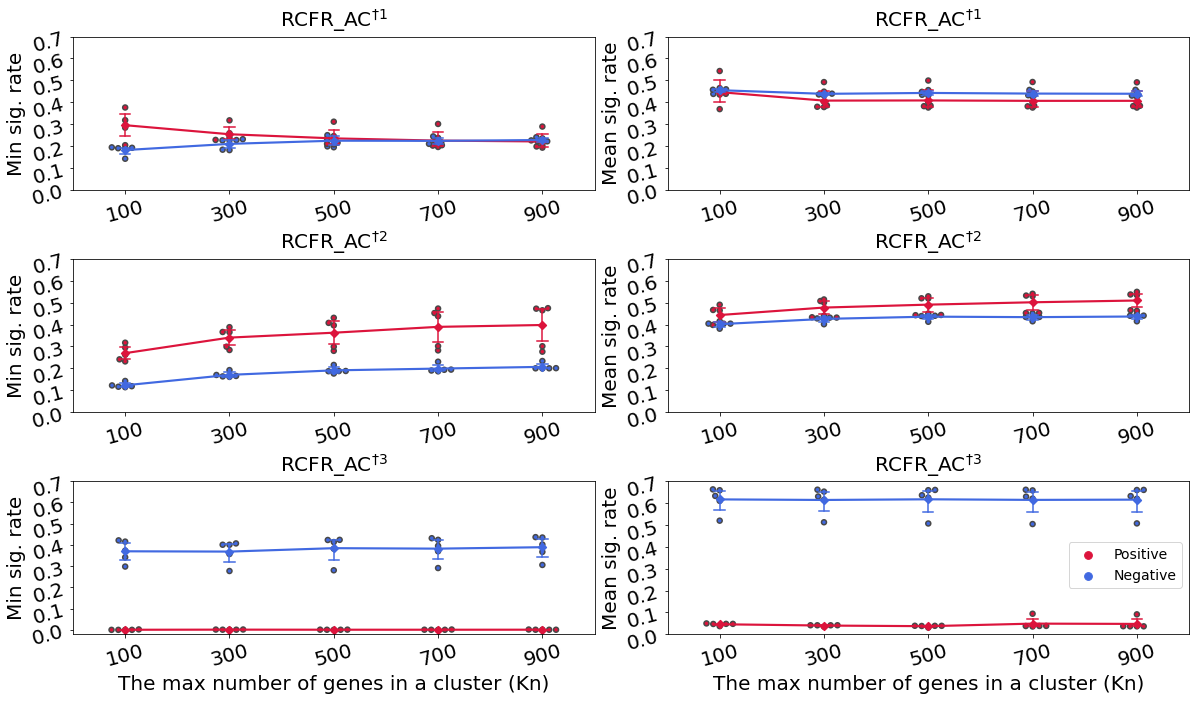

In [17]:
PerformancebyNumGene_CL(TestColName, TestLabelName, Agg_MetricTotal, ModelList, np.unique(Agg_MetricTotal['NumGene_CL']).tolist(), TitleList)
plt.savefig('./Figures/PerformancebyNumGene_CL.png')

### Performance difference over epoch

In [18]:
PerformDiffTab = Agg_MetricTotal.groupby(['Sign','NumGene_CL']).mean()[['MinSigRate','AvgSigRate']]
PerformDiffTab.to_csv('./MetricTables/PerformDiffTab.csv')